In [1]:
from brian2 import *
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
def calc_weight(M, alpha, mu, sigma):
    output = zeros((M,M))
    for i in np.arange(M):
        for j in np.arange(M):
            output[i,j] = exp(cos((2*pi*i/M) - (2*pi*j/M) - mu)/sigma**2)
    output = output * (alpha/np.max(output))
    output = 5.0 * fF * np.around(output/(5.0*fF))
    return output

In [3]:
MODE = 'adaptive'
PARASITICS = True

In [4]:
# Define various equations

if MODE == 'adaptive':
    neuron_eq = '''
        dVm/dt = ((glm + gpar) / Cm) * (Vm_r - Vm)  : volt
        dVt/dt = ((glt + gpar) / Ct) * (Vt_r - Vt)  : volt
        
        # dVm/dt = (glm / Cm) * (Vm_r - Vm) : volt
        # dVt/dt = (glt / Ct) * (Vt_r - Vt) : volt

        glm = flm * Cl                              : siemens
        glt = flt * Cl                              : siemens
        gpar = par_ctrl / par_leak_time * Cm : siemens
    '''
    reset_eq = '''
        Vm = Vm_r
        Vt = Vt * (Vt > Vm) + Vt_r * (Vt <= Vm)
    '''
    presyn_eq = '''
        Vm_old = Vm
        Vm = Vm_old + Vsyn
        Vt += (Cst/Ct) * (Vm_old - Vm_r)
    '''
else:
    neuron_eq = '''
        dVm/dt = (glm / Cm) * (Vm_r - Vm) : volt

        glm = flm * Cl                    : siemens
    '''
    reset_eq = '''
        Vm = Vm_r
    '''
    presyn_eq = '''
        Vm_old = Vm
        Vm = Vm_old + Vsyn
    '''

# Synapse equation is the same for both modes!
syn_eq = '''
    Vsyn = (W/Cm)*(Em - Vm) : volt
    Em                      : volt
    W                       : farad
'''

In [5]:
# IFAT specific definitions
fF = 0.001 * pF
Vdd = 5 * volt
Cm = Ct = 440 * fF
Cl = 2 * fF

W_vals  = np.array([5, 10, 20, 40, 80]) * fF
Em_vals = np.array([0, 1/3, 2/3, 1]) * Vdd

par_ctrl = float(PARASITICS)
par_leak_time = 12.5 * ms

In [6]:
# Model parameters
Vm_r = 1 * volt
flm  = 0 * kHz
Csm  = W_vals[0]

Vt_r = 3.5 * volt
flt  = 0 * MHz
Cst  = 0 * fF

M = 64

In [7]:
# Connectivity specifics
alpha = sum(W_vals)
mu1 = 0
mu2 = 2*pi/3
mu3 = pi
sigma = 36 * pi/180

In [8]:
# Preferred direction for cell
theta1 = pi/6
theta2 = 5*pi/6
theta3 = 9*pi/6
lam = 0.01 # meters
d1 = lam * np.asarray([cos(theta1),sin(theta1)])
d2 = lam * np.asarray([cos(theta2),sin(theta2)])
d3 = lam * np.asarray([cos(theta3),sin(theta3)])

In [9]:
def timedrandwalk(v=5, dt=0.001*second, time=10*second, size=5):
    nsteps = int(time/dt)
    rwpath = np.ones([nsteps,2]) * (size/2.)
    for step in np.arange(1,nsteps):
        if (step % 10*ms/dt):
            rwpath[step,:] = rwpath[step-1,:]
        else:
            while (np.abs(rwpath[step,:])>=(size/2.)).any():
                vel = v*np.random.random()
                theta=2*math.pi*np.random.random()
                dx = vel*math.cos(theta)
                dy = vel*math.sin(theta)
                rwpath[step,:] = rwpath[step-1,:] + [dx, dy]

    return rwpath

In [10]:
vel = timedrandwalk(v=0.01,dt=defaultclock.dt,time=10*second,size=3)

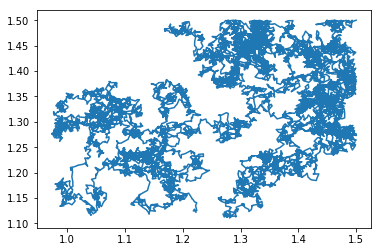

In [11]:
plot(vel[:,0],vel[:,1])

In [21]:
start_scope()

blair_exc = NeuronGroup(M, neuron_eq, threshold='Vm>Vt', reset=reset_eq, method='exact')
blair_exc.Vt = Vt_r
blair_exc.Vm = Vm_r

blair_inh = NeuronGroup(M, neuron_eq, threshold='Vm>Vt', reset=reset_eq, method='exact')
blair_inh.Vt = Vt_r
blair_inh.Vm = Vm_r

exc2inh = Synapses(blair_exc, blair_inh, syn_eq, on_pre=presyn_eq)
exc2inh.connect()
exc2inh.Em = Em_vals[3]
exc2inh.W = calc_weight(M,alpha,mu1,sigma).flatten()

inh2exc = Synapses(blair_inh, blair_exc, syn_eq, on_pre=presyn_eq)
inh2exc.connect()
inh2exc.Em = Em_vals[0]
inh2exc.W  = calc_weight(M,alpha,mu2,sigma).flatten()

inh2inh = Synapses(blair_inh, blair_inh, syn_eq, on_pre=presyn_eq)
inh2inh.connect()
inh2inh.Em = Em_vals[0]
inh2inh.W = calc_weight(M,alpha,mu1,sigma).flatten()

prates = '(3 + 20*veldot(t))*kHz'
PoisIn = PoissonGroup(M,rates=prates)
p2exc = Synapses(PoisIn, blair_exc, syn_eq, on_pre=presyn_eq)
p2exc.connect('j==i')
p2exc.Em = Em_vals[3]
p2exc.W = W_vals[2] + W_vals[0]# + W_vals[0]

i_spmon = SpikeMonitor(blair_inh)
e_spmon = SpikeMonitor(blair_exc)
e_vmon = StateMonitor(blair_exc, 'Vm', record=True)
inrate = PopulationRateMonitor(PoisIn)
erate00 = PopulationRateMonitor(blair_exc[:1])
erate15 = PopulationRateMonitor(blair_exc[15:16])
erate31 = PopulationRateMonitor(blair_exc[31:32])
erate47 = PopulationRateMonitor(blair_exc[47:48])
ratecheck = StateMonitor(PoisIn, 'rates',record=True)

store()

In [22]:
veldot = TimedArray(np.dot(vel,d1),dt=defaultclock.dt)
restore()
run(10*second)

WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 5 lines of abstract code, first line is: "Vm_old := Vm (constant)"
 [brian2.codegen.generators.base]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 5 lines of abstract code, first line is: "Vm_old := Vm (constant)"
 [brian2.codegen.generators.base]
WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 5 lines of abstract code, first line is: "Vm_old := Vm (constant)"
 [brian2.codegen.generators.base]
WARNING    Came across an abstract code block tha

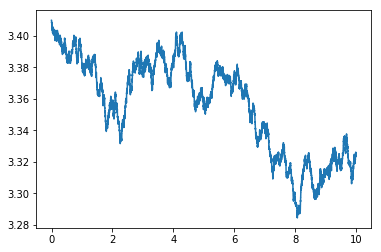

In [23]:
plot(ratecheck.t/second, ratecheck.rates[0]/kHz)

In [ ]:
start_scope()

# blair_exc = NeuronGroup(M, neuron_eq, threshold='Vm>Vt', reset=reset_eq, method='exact')
# blair_exc.Vt = Vt_r
# blair_exc.Vm = Vm_r

# blair_inh = NeuronGroup(M, neuron_eq, threshold='Vm>Vt', reset=reset_eq, method='exact')
# blair_inh.Vt = Vt_r
# blair_inh.Vm = Vm_r

G1 = NeuronGroup(2*M, neuron_eq, threshold='Vm>Vt', reset=reset_eq, method='exact')
G1.Vt = Vt_r
G1.Vm = Vm_r
G1_exc = G1[:M]
G1_inh = G1[M:]

G1_e2i = Synapses(G1_exc, G1_inh, syn_eq, on_pre=presyn_eq)
G1_e2i.Em = Em_vals[3]
G1_e2i.W = calc_weight(M,alpha,mu1,sigma).flatten()

# exc2inh = Synapses(blair_exc, blair_inh, syn_eq, on_pre=presyn_eq)
# exc2inh.connect()
# exc2inh.Em = Em_vals[3]
# exc2inh.W = calc_weight(M,alpha,mu1,sigma).flatten()

# inh2exc = Synapses(blair_inh, blair_exc, syn_eq, on_pre=presyn_eq)
# inh2exc.connect()
# inh2exc.Em = Em_vals[0]
# inh2exc.W  = calc_weight(M,alpha,mu2,sigma).flatten()

# inh2inh = Synapses(blair_inh, blair_inh, syn_eq, on_pre=presyn_eq)
# inh2inh.connect()
# inh2inh.Em = Em_vals[0]
# inh2inh.W = calc_weight(M,alpha,mu1,sigma).flatten()

prates = '(3 + 20*veldot(t))*kHz'
PoisIn = PoissonGroup(M,rates=prates)
p2exc = Synapses(PoisIn, blair_exc, syn_eq, on_pre=presyn_eq)
p2exc.connect('j==i')
p2exc.Em = Em_vals[3]
p2exc.W = W_vals[2] + W_vals[0]# + W_vals[0]

i_spmon = SpikeMonitor(blair_inh)
e_spmon = SpikeMonitor(blair_exc)
e_vmon = StateMonitor(blair_exc, 'Vm', record=True)
inrate = PopulationRateMonitor(PoisIn)
erate00 = PopulationRateMonitor(blair_exc[:1])
erate15 = PopulationRateMonitor(blair_exc[15:16])
erate31 = PopulationRateMonitor(blair_exc[31:32])
erate47 = PopulationRateMonitor(blair_exc[47:48])
ratecheck = StateMonitor(PoisIn, 'rates',record=True)

store()

In [25]:
calc_weight(M,alpha,mu1,sigma)/fF

array([[155., 155., 150., ..., 140., 150., 155.],
       [155., 155., 155., ..., 130., 140., 150.],
       [150., 155., 155., ..., 115., 130., 140.],
       ...,
       [140., 130., 115., ..., 155., 155., 150.],
       [150., 140., 130., ..., 155., 155., 155.],
       [155., 150., 140., ..., 150., 155., 155.]])

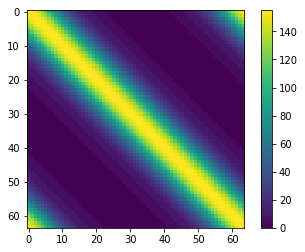

In [27]:
imshow(calc_weight(M,alpha,mu1,sigma)/fF); colorbar()

In [28]:
w = calc_weight(M,alpha,mu1,sigma)/fF

In [30]:
w[:,10]

array([ 50.,  60.,  75.,  85., 100., 115., 130., 140., 150., 155., 155.,
       155., 150., 140., 130., 115., 100.,  85.,  75.,  60.,  50.,  40.,
        30.,  25.,  20.,  15.,  10.,  10.,  10.,   5.,   5.,   5.,   5.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   5.,   5.,   5.,
         5.,  10.,  10.,  10.,  15.,  20.,  25.,  30.,  40.])